In [2]:
import polars as pl 
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
endpoint_types = ["toxcast_cellbased", "toxcast_cellfree", "toxcast_cytotox", "axiom"]

pred_df = []
for et in endpoint_types:
    preds = pl.read_parquet(f"./compiled_results/compiled_{et}_metrics.parquet")
    preds = preds.with_columns(
        (pl.col("Metadata_Count_0") + pl.col("Metadata_Count_1")).alias("Total_Compounds"),
        pl.lit(et).alias("Endpoint_type")
    )
    pred_df.append(preds)

pred_df = pl.concat(pred_df, how="vertical")
pred_df = pred_df.with_columns(
    pl.when(pl.col("Endpoint_type") == "axiom").then(pl.lit("axiom_cytotox")).otherwise(pl.col("Endpoint_type")).alias("Endpoint_type")
)

pred_df = (pred_df
            .filter(pl.col("Model_type") == "Actual")
            .filter(pl.col("Feat_type") == "dino")
            .filter(pl.col("Metadata_AggType") == "all"))

In [52]:
cell_df = pred_df.filter(pl.col("Endpoint_type") == "toxcast_cellbased")

cell_df = cell_df.with_columns(
    pl.when(pl.col("Metadata_Label").str.contains("_AR_")).then(pl.lit("AR")).otherwise(pl.lit("Other")).alias("AR")
)

ar_assays = cell_df.filter(pl.col("AR") == "AR").select("Metadata_Label").to_series().to_list()
ar_df = cell_df.filter(pl.col("Metadata_Label").is_in(ar_assays))
ar_assays

['TOX21_AR_LUC_MDAKB2_Agonist_3uM_Nilutamide',
 'OT_AR_ARSRC1_0480',
 'TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881',
 'ACEA_AR_agonist_80hr',
 'OT_AR_ARSRC1_0960',
 'TOX21_AR_BLA_Antagonist_ratio',
 'TOX21_AR_LUC_MDAKB2_Agonist',
 'ACEA_AR_antagonist_80hr',
 'TOX21_AR_BLA_Agonist_ratio',
 'TOX21_AR_LUC_MDAKB2_Antagonist_0.5nM_R1881']

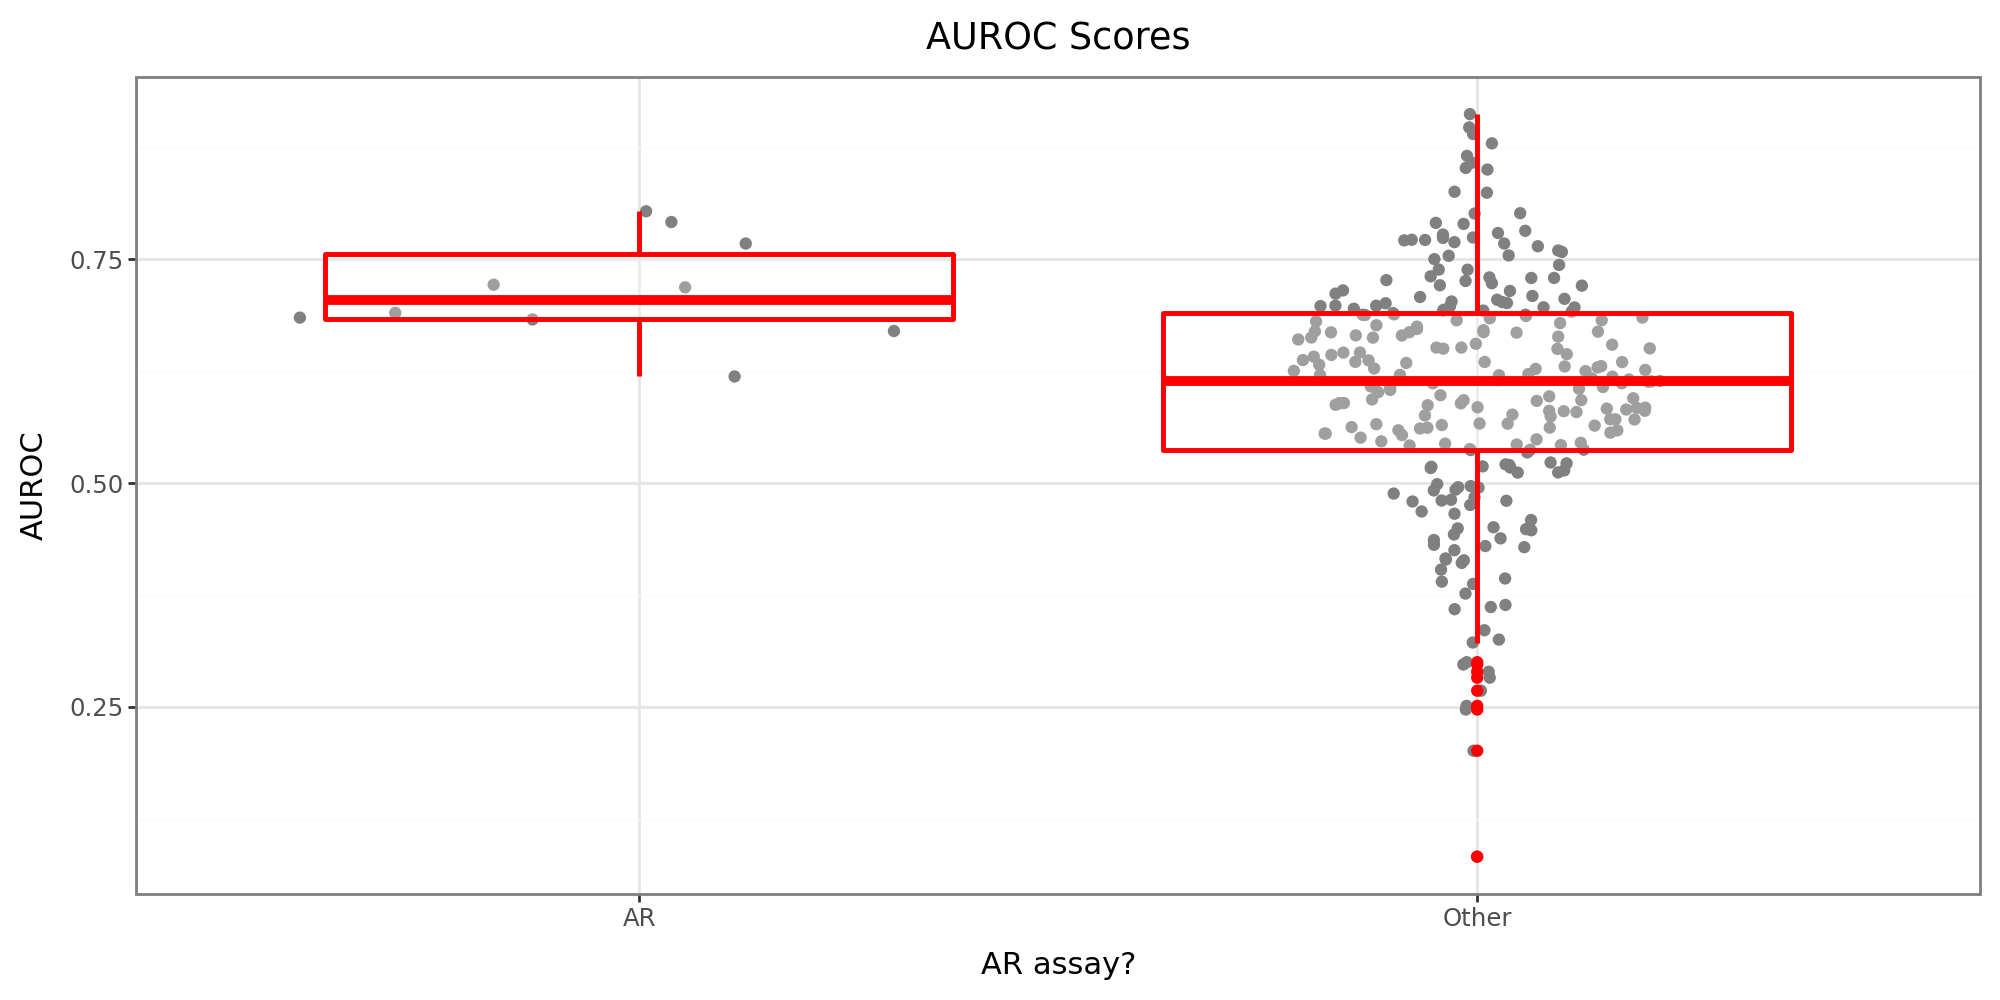

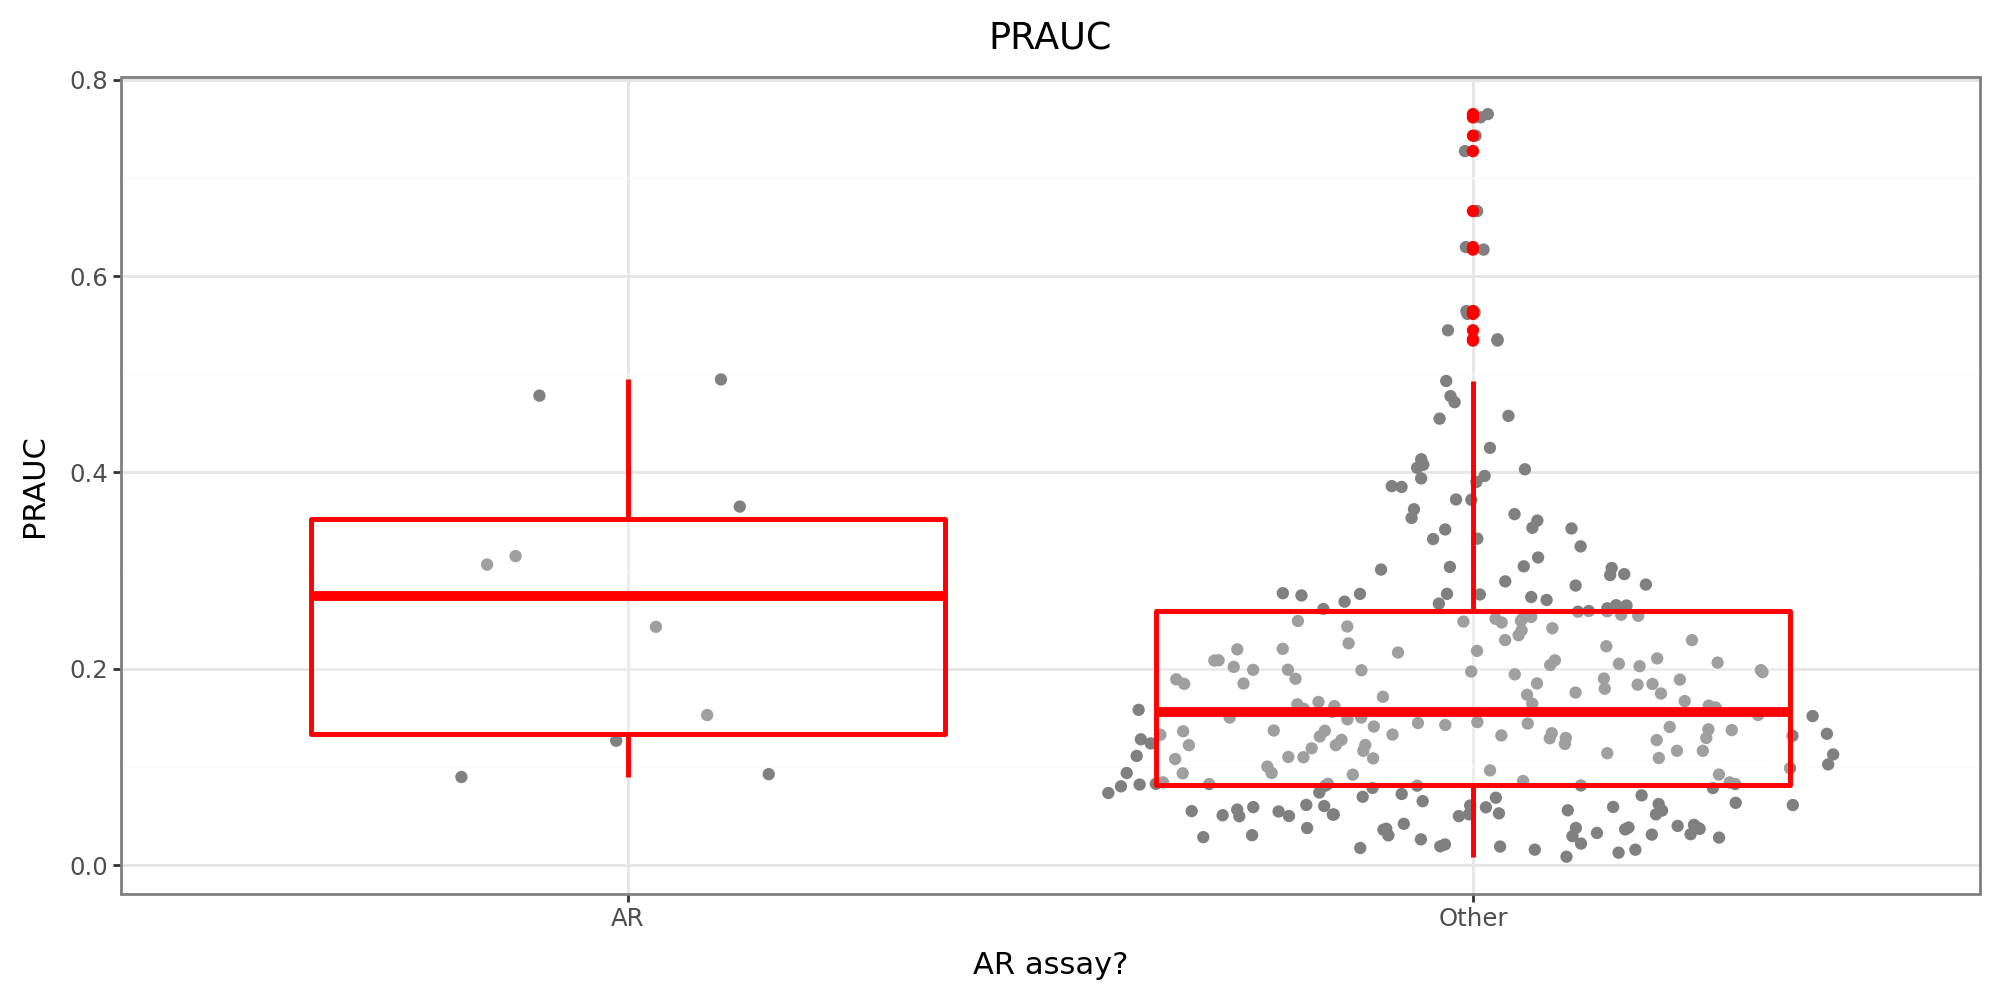

In [53]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(cell_df, aes(x='AR', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores', x='AR assay?', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cell_df, aes(x='AR', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='PRAUC', x='AR assay?', y='PRAUC') 
    + theme_bw()
)
plot.show()

## Examine AR annotations

In [11]:
labels = pl.read_parquet("../1_snakemake/inputs/annotations/toxcast_cellbased_binary.parquet").select(
    ["OASIS_ID"] + ar_assays
)

oasis_ids = pl.read_parquet("../1_snakemake/outputs/cellprofiler/mad_featselect/classifier_results/toxcast_cellbased_binary_predictions.parquet").select("Metadata_OASIS_ID").to_series().unique().to_list()

labels = labels.filter(pl.col("OASIS_ID").is_in(oasis_ids))

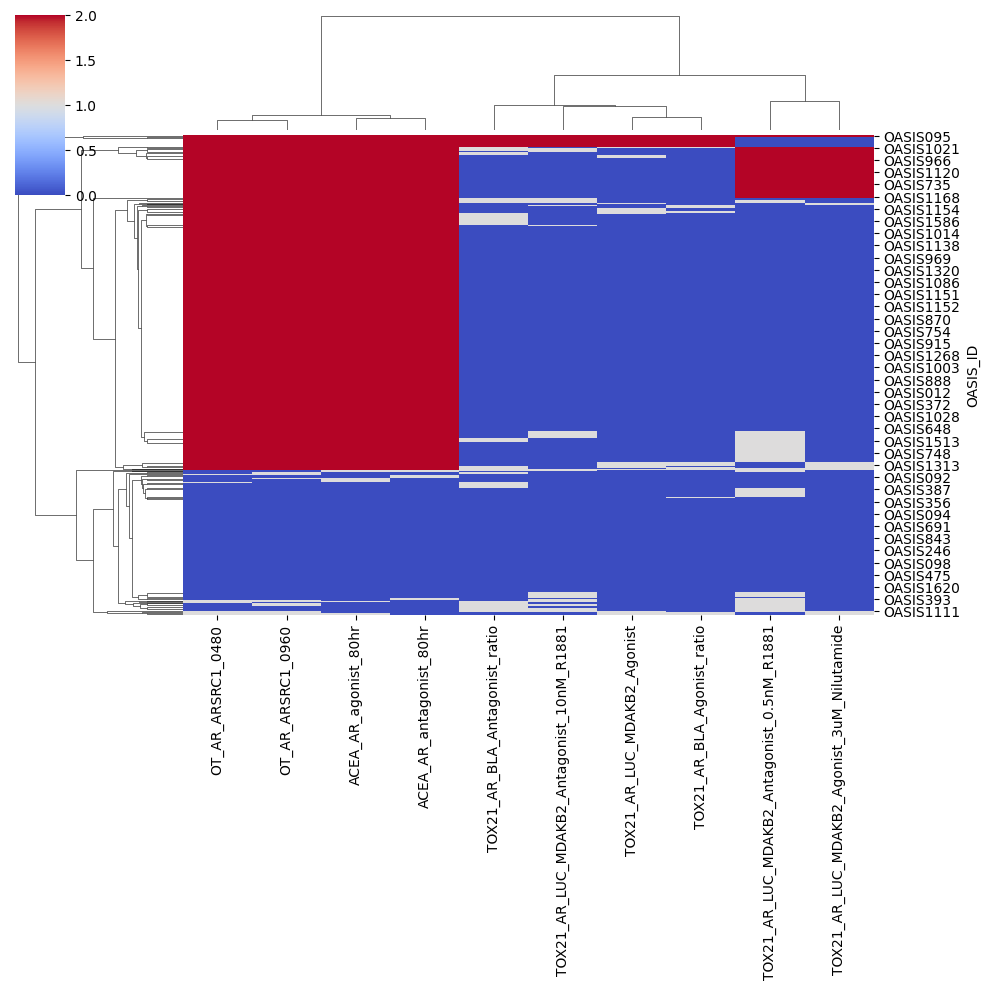

In [12]:
df = labels.to_pandas().set_index("OASIS_ID")
df = df.fillna(2)

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.clustermap(
    df,
    cmap=cmap,
    row_cluster=True,
    col_cluster=True,
    vmin=0, vmax=2
)
plt.show()

In [39]:
# best agonist: TOX21_AR_LUC_MDAKB2_Agonist_3uM_Nilutamide
# best antagonist: TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881

ar_ag = labels.filter(pl.col("TOX21_AR_LUC_MDAKB2_Agonist_3uM_Nilutamide") == 1).select("OASIS_ID").to_series().to_list()
ar_antag = labels.filter(pl.col("TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881") == 1).select("OASIS_ID").to_series().to_list()

ar_ids = list(set(ar_ag + ar_antag))

[i for i in ar_ag if i in ar_antag]

['OASIS1111', 'OASIS1213', 'OASIS987']

In [15]:
ar_1 = labels.filter((pl.col("TOX21_AR_LUC_MDAKB2_Agonist_3uM_Nilutamide") == 1) | (pl.col("TOX21_AR_LUC_MDAKB2_Agonist_3uM_Nilutamide") == 0)).select("OASIS_ID").to_series().to_list()
ar_2 = labels.filter((pl.col("TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881") == 1) | (pl.col("TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881") == 0)).select("OASIS_ID").to_series().to_list()

all_ar = list(set(ar_1 + ar_2))

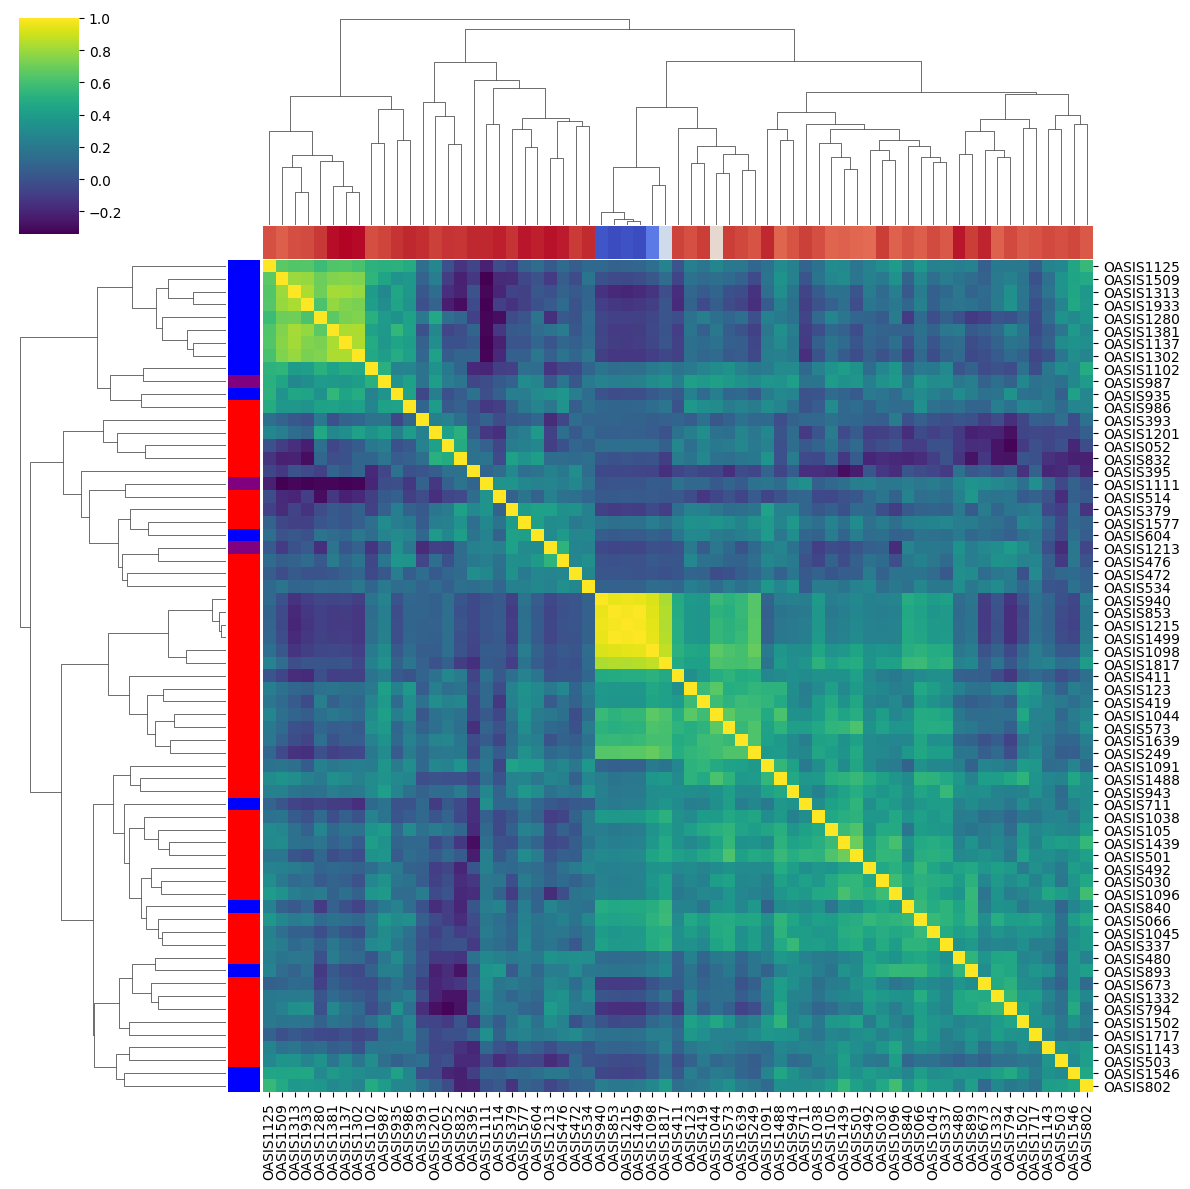

In [ ]:
# all
agg_prof = pl.read_parquet("../1_snakemake/outputs/dino/mad_featselect/aggregated_profiles/agg.parquet")
agg_prof = agg_prof.filter(pl.col("Metadata_AggType") == "all").drop(["Metadata_AggType"]).filter(
    pl.col("Metadata_OASIS_ID").is_in(ar_ids)
)

agg_prof = agg_prof.with_columns(
    pl.when(pl.col("Metadata_OASIS_ID").is_in(ar_ag) & pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Both"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_ag))
      .then(pl.lit("Agonist"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Antagonist"))
      .alias("Metadata_AR_type")
)

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

cosine_distance_matrix = squareform(pdist(agg_prof.drop(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]), metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata = agg_prof.select(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]).to_pandas()
norm = Normalize(vmin=metadata["Cell_Count"].min(), vmax=metadata["Cell_Count"].max())

cell_count_colors = cm.coolwarm(norm(metadata["Cell_Count"]))

ar_type_color_map = {"Agonist": "blue", "Antagonist": "red", "Both": "purple"}
row_col_colors = metadata["Metadata_AR_type"].map(ar_type_color_map).to_numpy()

g = sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=metadata["Metadata_OASIS_ID"],
    yticklabels=metadata["Metadata_OASIS_ID"],
    figsize=(12, 12),
    row_colors=row_col_colors,
    col_colors=cell_count_colors
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

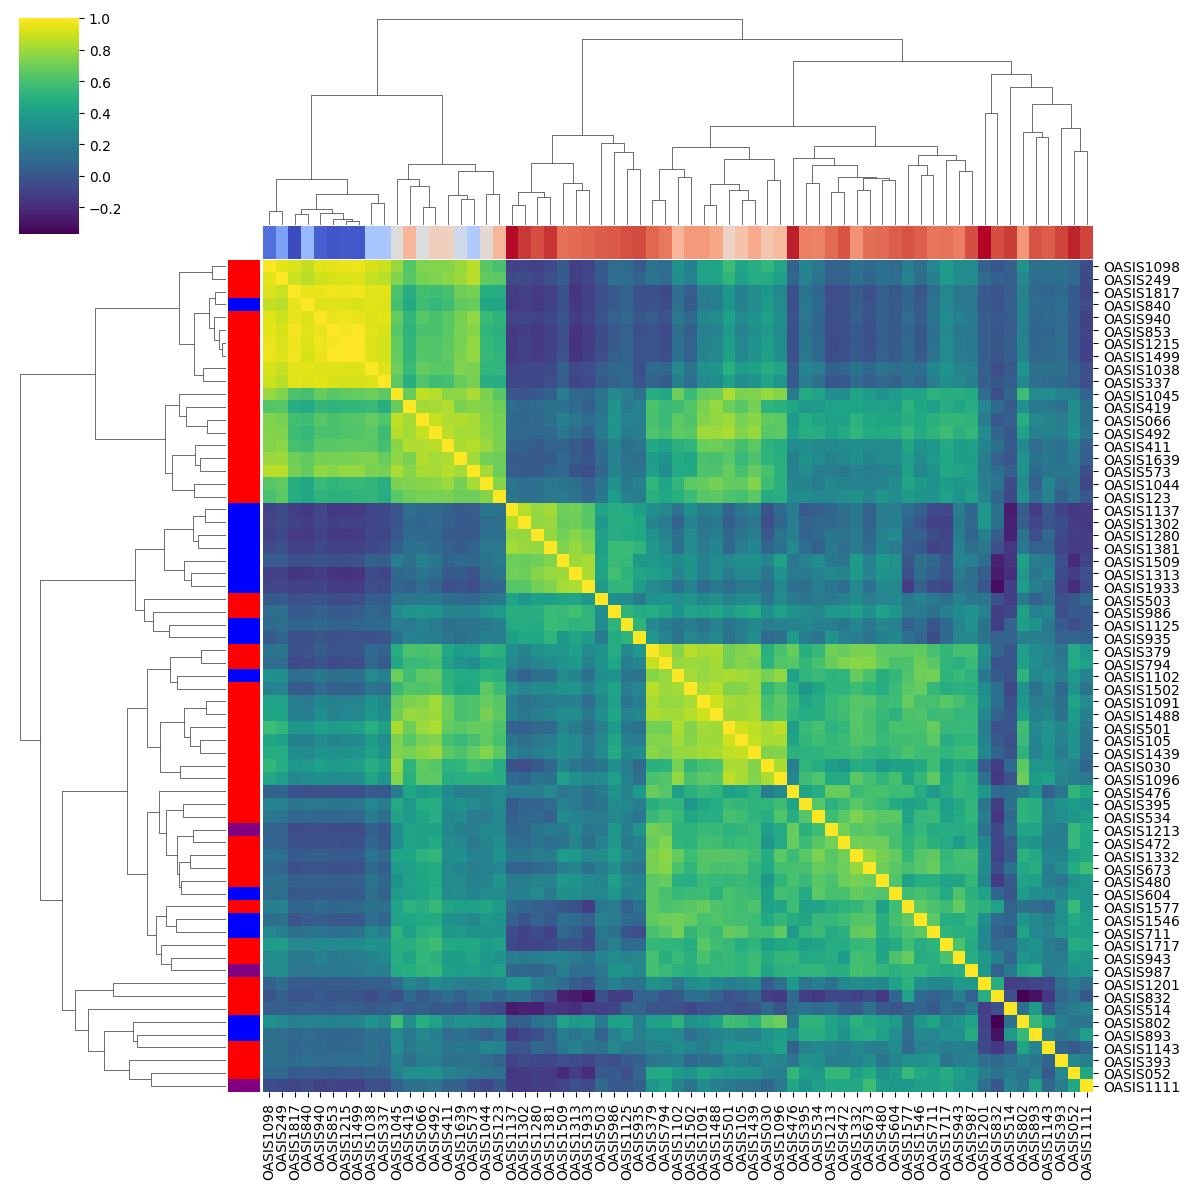

In [ ]:
# allpod
agg_prof = pl.read_parquet("../1_snakemake/outputs/dino/mad_featselect/aggregated_profiles/agg.parquet")
agg_prof = agg_prof.filter(pl.col("Metadata_AggType") == "allpod").drop(["Metadata_AggType"]).filter(
    pl.col("Metadata_OASIS_ID").is_in(ar_ids)
)

agg_prof = agg_prof.with_columns(
    pl.when(pl.col("Metadata_OASIS_ID").is_in(ar_ag) & pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Both"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_ag))
      .then(pl.lit("Agonist"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Antagonist"))
      .alias("Metadata_AR_type")
)

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

cosine_distance_matrix = squareform(pdist(agg_prof.drop(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]), metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata = agg_prof.select(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]).to_pandas()
norm = Normalize(vmin=metadata["Cell_Count"].min(), vmax=metadata["Cell_Count"].max())

cell_count_colors = cm.coolwarm(norm(metadata["Cell_Count"]))

ar_type_color_map = {"Agonist": "blue", "Antagonist": "red", "Both": "purple"}
row_col_colors = metadata["Metadata_AR_type"].map(ar_type_color_map).to_numpy()

g = sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=metadata["Metadata_OASIS_ID"],
    yticklabels=metadata["Metadata_OASIS_ID"],
    figsize=(12, 12),
    row_colors=row_col_colors,
    col_colors=cell_count_colors
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

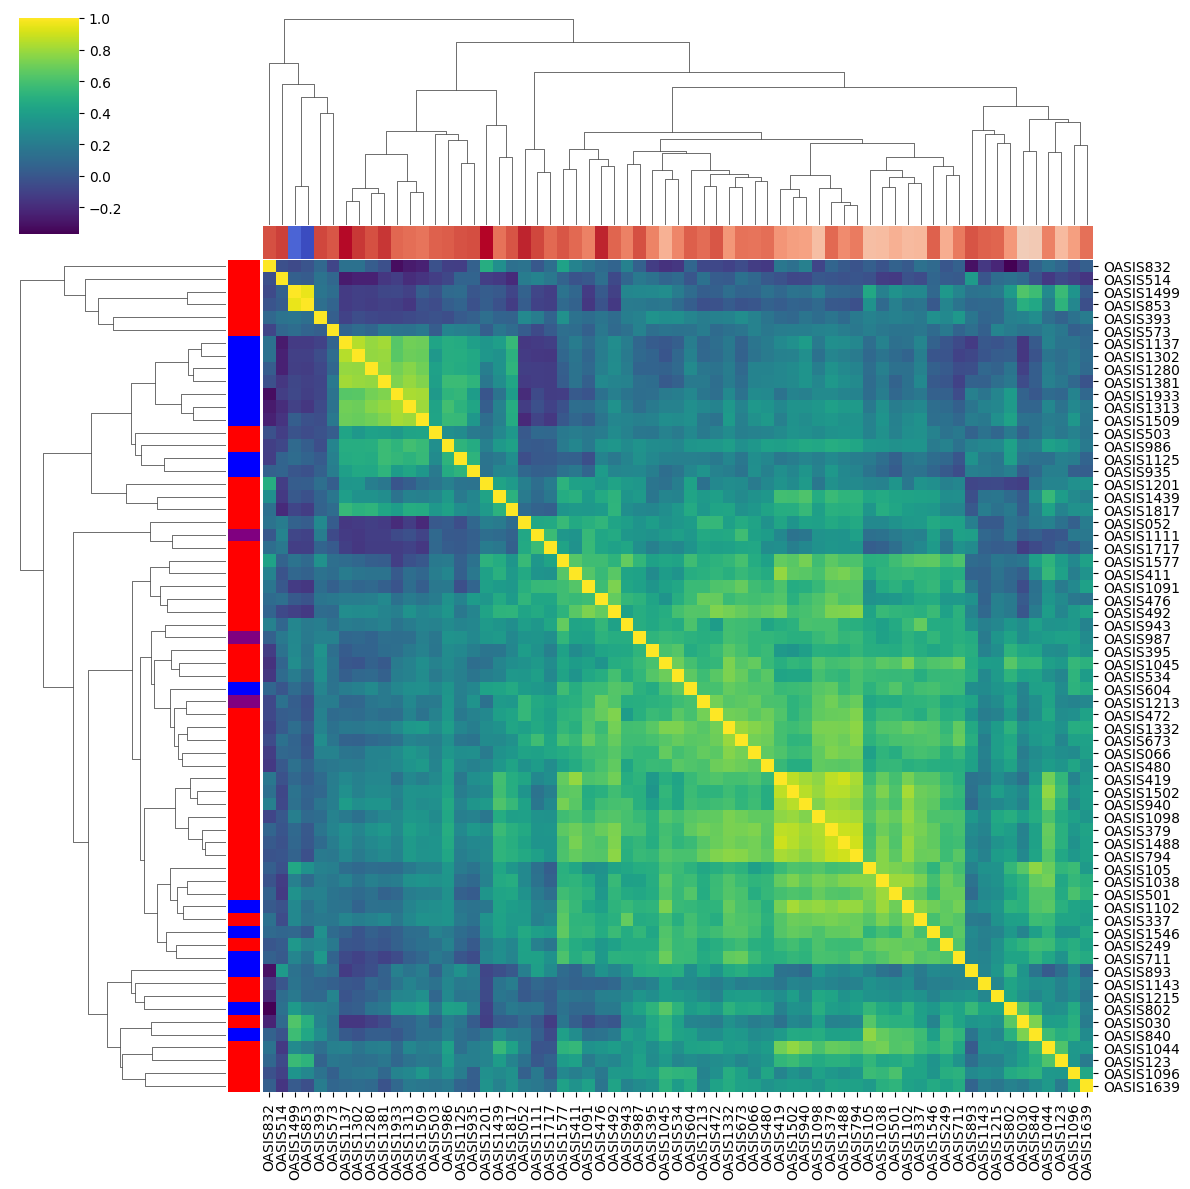

In [ ]:
# allpodcc
agg_prof = pl.read_parquet("../1_snakemake/outputs/dino/mad_featselect/aggregated_profiles/agg.parquet")
agg_prof = agg_prof.filter(pl.col("Metadata_AggType") == "allpodcc").drop(["Metadata_AggType"]).filter(
    pl.col("Metadata_OASIS_ID").is_in(ar_ids)
)

agg_prof = agg_prof.with_columns(
    pl.when(pl.col("Metadata_OASIS_ID").is_in(ar_ag) & pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Both"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_ag))
      .then(pl.lit("Agonist"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Antagonist"))
      .alias("Metadata_AR_type")
)

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

cosine_distance_matrix = squareform(pdist(agg_prof.drop(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]), metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata = agg_prof.select(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]).to_pandas()
norm = Normalize(vmin=metadata["Cell_Count"].min(), vmax=metadata["Cell_Count"].max())

cell_count_colors = cm.coolwarm(norm(metadata["Cell_Count"]))

ar_type_color_map = {"Agonist": "blue", "Antagonist": "red", "Both": "purple"}
row_col_colors = metadata["Metadata_AR_type"].map(ar_type_color_map).to_numpy()

g = sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=metadata["Metadata_OASIS_ID"],
    yticklabels=metadata["Metadata_OASIS_ID"],
    figsize=(12, 12),
    row_colors=row_col_colors,
    col_colors=cell_count_colors
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [ ]:
strong_ag = ["OASIS1137", "OASIS1302", "OASIS1280", "OASIS1381", "OASIS1509", "OASIS1313", "OASIS1933"]
strong_antag = ["OASIS419", "OASIS1502", "OASIS940", "OASIS1098", "OASIS379", "OASIS1488", "OASIS794"]

oasis = pl.read_csv("../1_snakemake/inputs/annotations/v5_oasis_03Sept2024_simple.csv")

oasis_ag = oasis.filter(pl.col("OASIS_ID").is_in(strong_ag))
oasis_antag = oasis.filter(pl.col("OASIS_ID").is_in(strong_antag))

In [4]:
oasis_ag.select("PREFERRED_NAME").to_series().to_list()

['Budesonide',
 'Beclomethasone',
 'Deflazacort',
 'Fludrocortisone',
 'Hydrocortisone',
 'Prednisolone',
 'Methylprednisolone']

In [43]:
oasis_antag.select("PREFERRED_NAME").to_series().to_list()

['Fipronil',
 'Azoxystrobin',
 'Bortezomib',
 'Pazopanib',
 'Bicalutamide',
 '5-Azacytidine',
 'Digoxin']

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



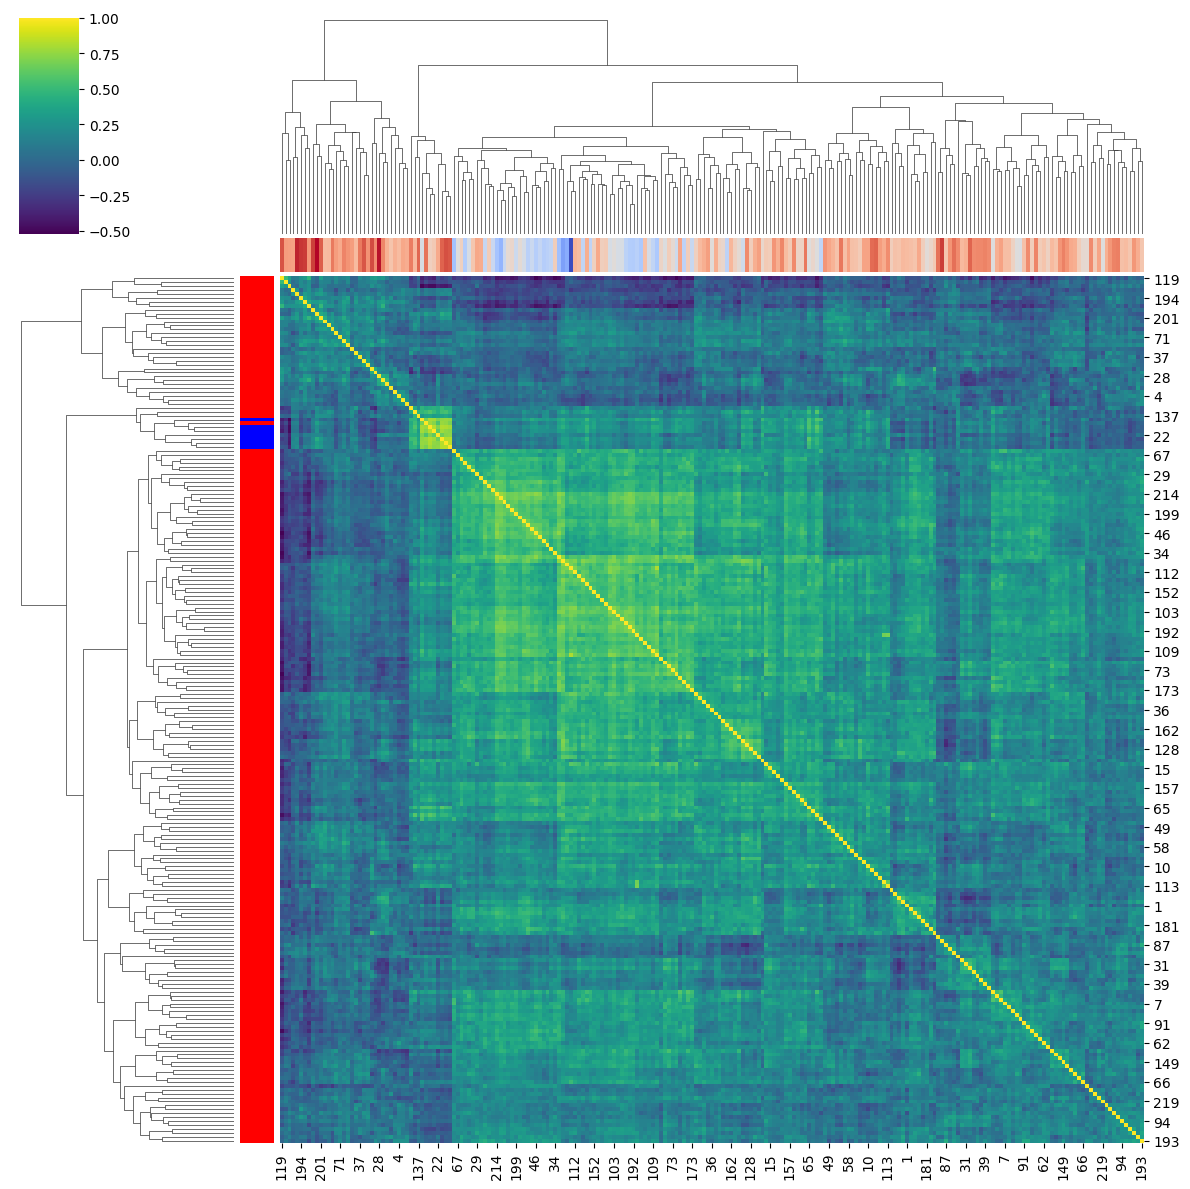

In [ ]:
# Compare all untested compounds to the glucocorticoid cluster (AR agonist)
import pycytominer

prof = pl.read_parquet("../1_snakemake/outputs/dino/mad_featselect/profiles/mad_featselect.parquet").rename({"Metadata_Count_Cells": "Cell_Count"})
pods = pl.read_parquet("../1_snakemake/outputs/dino/mad_featselect/curves/pods.parquet")

controls = ["DMSO"]
prof = prof.filter(~pl.col("Metadata_Compound").is_in(controls))

# Add POD
prof = prof.join(
    pods.select(["Metadata_Compound", "bmd", "cc_POD"]).rename({
        "bmd": "Metadata_POD",
        "cc_POD": "Metadata_ccPOD",
    }),
    on="Metadata_Compound",
    how="left",
)

feat_cols = [i for i in prof.columns if "Metadata" not in i]


agg_prof = pl.from_pandas(
    pycytominer.aggregate(
        prof.filter(
            (pl.col("Metadata_Log10Conc") < pl.col("Metadata_ccPOD")),
        ).to_pandas(),
        strata=["Metadata_OASIS_ID"],
        features=feat_cols
    )
)

agg_prof = agg_prof.filter(
    (pl.col("Metadata_OASIS_ID").is_in(strong_ag)) | (~pl.col("Metadata_OASIS_ID").is_in(all_ar))
)

agg_prof = agg_prof.with_columns(
    pl.when(pl.col("Metadata_OASIS_ID").is_in(strong_ag))
      .then(pl.lit("Glucocorticoid"))
      .otherwise(pl.lit("Other"))
      .alias("Metadata_GR_type")
)

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

cosine_distance_matrix = squareform(pdist(agg_prof.drop(["Metadata_OASIS_ID", "Metadata_GR_type", "Cell_Count"]), metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata = agg_prof.select(["Metadata_OASIS_ID", "Metadata_GR_type", "Cell_Count"]).to_pandas()
norm = Normalize(vmin=metadata["Cell_Count"].min(), vmax=metadata["Cell_Count"].max())

cell_count_colors = cm.coolwarm(norm(metadata["Cell_Count"]))

ar_type_color_map = {"Glucocorticoid": "blue", "Other": "red"}
row_col_colors = metadata["Metadata_GR_type"].map(ar_type_color_map).to_numpy()

g = sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    #xticklabels=metadata["Metadata_OASIS_ID"],
    #yticklabels=metadata["Metadata_OASIS_ID"],
    figsize=(12, 12),
    row_colors=row_col_colors,
    col_colors=cell_count_colors
)
#g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
#g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [47]:
import plotly.express as px
import numpy as np

cs_re_ordered = cosine_similarity_matrix[np.ix_(g.dendrogram_row.reordered_ind,g.dendrogram_row.reordered_ind)]

fig = px.imshow(cs_re_ordered,
                 color_continuous_scale='RdBu_r',
                 aspect="auto",
                 x=metadata.iloc[g.dendrogram_row.reordered_ind].Metadata_OASIS_ID.astype(str),
                 y=metadata.iloc[g.dendrogram_row.reordered_ind].Metadata_OASIS_ID.astype(str),
                 width=1500,
                 height=1500
)
fig.update_layout(
    xaxis=dict(showticklabels=False),  # Hide x-axis tick labels
    yaxis=dict(showticklabels=False)   # Hide y-axis tick labels
)
# Customize hover
fig.update_traces(
    hovertemplate='x: %{x}<br>y: %{y}<br>z: %{z}'
)
fig.show()

In [37]:
new_gr_agonist = ["OASIS745", "OASIS1760", "OASIS1880", "OASIS773"]
oasis_new_gr = oasis.filter(pl.col("OASIS_ID").is_in(new_gr_agonist))

oasis_new_gr.select("PREFERRED_NAME").to_series().to_list()

['Gilteritinib', 'Sunitinib', 'Mometasone', 'Lorlatinib']